In [399]:
# Import các thư viện cần thiết
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


In [401]:
# Khai báo đường dẫn đến thư mục chứa chữ ký
DATASET_PATH = "C:/Model/Signature/signatures"  # Cập nhật theo đường dẫn của bạn
REAL_PATH = os.path.join(DATASET_PATH, "full_org")  # Chữ ký thật
FAKE_PATH = os.path.join(DATASET_PATH, "full_forg")  # Chữ ký giả

#Khai phá dữ liệu EDA
# Kiểm tra số lượng ảnh trong từng lớp
# Đếm số lượng ảnh trong mỗi thư mục
num_real = len(os.listdir(REAL_PATH))
num_fake = len(os.listdir(FAKE_PATH))

print(f"Số lượng chữ ký thật: {num_real}")
print(f"Số lượng chữ ký giả: {num_fake}")

Số lượng chữ ký thật: 1320
Số lượng chữ ký giả: 1320


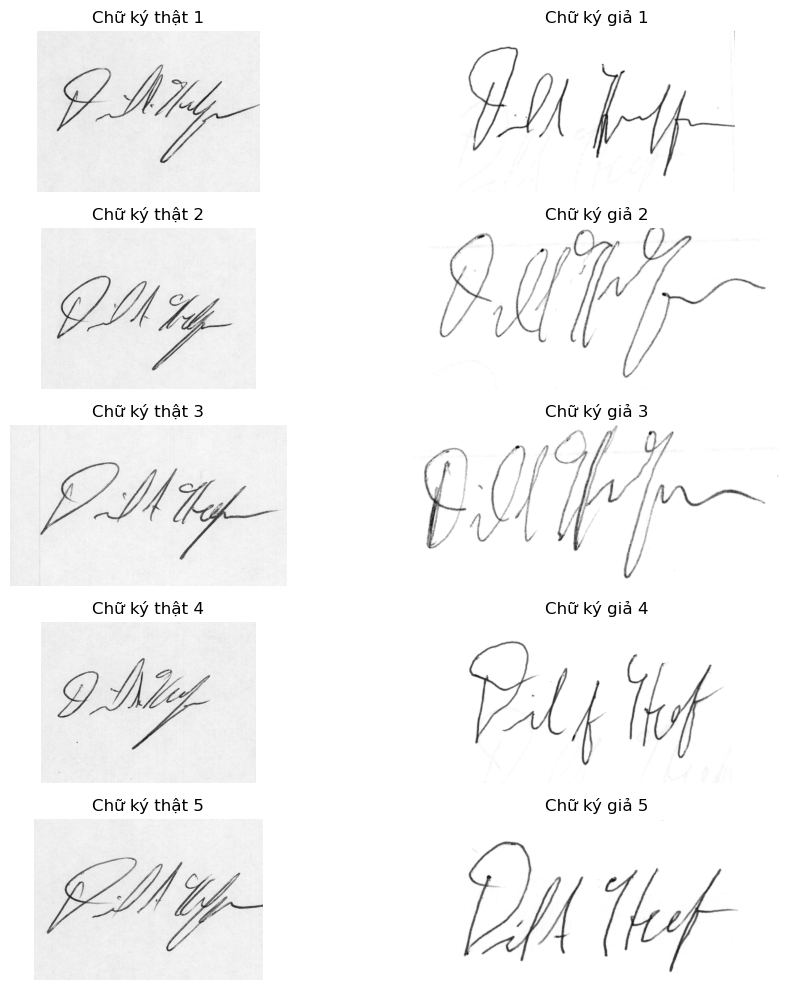

In [149]:
def show_signature_pairs(real_folder, fake_folder, num_samples=5):
    # Lọc danh sách file hợp lệ (bỏ qua Thumbs.db)
    real_files = sorted([f for f in os.listdir(real_folder) if not f.lower().endswith(".db")])
    fake_files = sorted([f for f in os.listdir(fake_folder) if not f.lower().endswith(".db")])

    num_samples = min(num_samples, len(real_files), len(fake_files))  

    plt.figure(figsize=(10, num_samples * 2))

    for i in range(num_samples):
        real_path = os.path.join(real_folder, real_files[i])
        fake_path = os.path.join(fake_folder, fake_files[i])

        real_img = cv2.imread(real_path, cv2.IMREAD_GRAYSCALE)
        fake_img = cv2.imread(fake_path, cv2.IMREAD_GRAYSCALE)

        if real_img is None or fake_img is None:
            print(f"Lỗi đọc ảnh: {real_path} hoặc {fake_path}")
            continue

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(real_img, cmap='gray')
        plt.axis('off')
        plt.title(f"Chữ ký thật {i+1}")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(fake_img, cmap='gray')
        plt.axis('off')
        plt.title(f"Chữ ký giả {i+1}")

    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị
show_signature_pairs(REAL_PATH, FAKE_PATH, num_samples=5)


In [403]:
import os
import cv2
import random

# Khai báo đường dẫn đến thư mục chứa chữ ký
DATASET_PATH = "C:/Model/Signature/signatures"  # Cập nhật theo đường dẫn của bạn
REAL_PATH = os.path.join(DATASET_PATH, "full_org")  # Chữ ký thật
FAKE_PATH = os.path.join(DATASET_PATH, "full_forg")  # Chữ ký giả
AUGMENTED_REAL_PATH = os.path.join(DATASET_PATH, "full_org_augmented")  # Thư mục lưu chữ ký thật đã tăng cường
AUGMENTED_FAKE_PATH = os.path.join(DATASET_PATH, "full_forg_augmented")  # Thư mục lưu chữ ký giả đã tăng cường

# xoay ảnh
def rotate_image(image, angle):
    """Xoay ảnh theo góc nhất định"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Tạo ma trận xoay
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Xoay ảnh và giữ nguyên kích thước
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated

# Tăng cường dữ liệu bằng cách xoay ảnh
def augment_data(input_folder, output_folder, augment_percentage, angles=[30,40]):
    """Xoay ảnh trong thư mục với các góc khác nhau và lưu ảnh mới"""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Lấy danh sách file ảnh
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Sao chép toàn bộ ảnh gốc sang thư mục mới
    for file_name in image_files:
        img_path = os.path.join(input_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(os.path.join(output_folder, file_name), img)
    
    # Tính số lượng ảnh cần tăng cường để đạt augment_percentage
    num_images = len(image_files)
    num_to_augment = int(num_images * augment_percentage)
    
    # Chọn ngẫu nhiên các ảnh để tăng cường
    augment_files = random.sample(image_files, num_to_augment)
    
    # Tăng cường dữ liệu cho các ảnh được chọn
    for file_name in augment_files:
        img_path = os.path.join(input_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Xoay ảnh với từng góc và lưu
        for angle in angles:
            rotated_img = rotate_image(img, angle)
            new_file_name = f"rotated_{angle}_{file_name}"
            cv2.imwrite(os.path.join(output_folder, new_file_name), rotated_img)

# Tăng cường dữ liệu
augment_data(REAL_PATH, AUGMENTED_REAL_PATH, augment_percentage=1.0, angles=[30,40])
augment_data(FAKE_PATH, AUGMENTED_FAKE_PATH, augment_percentage=1.0, angles=[30,40])

# Kiểm tra số lượng ảnh trong từng lớp sau khi tăng cường
num_real = len(os.listdir(AUGMENTED_REAL_PATH))
num_fake = len(os.listdir(AUGMENTED_FAKE_PATH))

print(f"Số lượng chữ ký thật sau tăng cường: {num_real}")
print(f"Số lượng chữ ký giả sau tăng cường: {num_fake}")

Số lượng chữ ký thật sau tăng cường: 3960
Số lượng chữ ký giả sau tăng cường: 3960


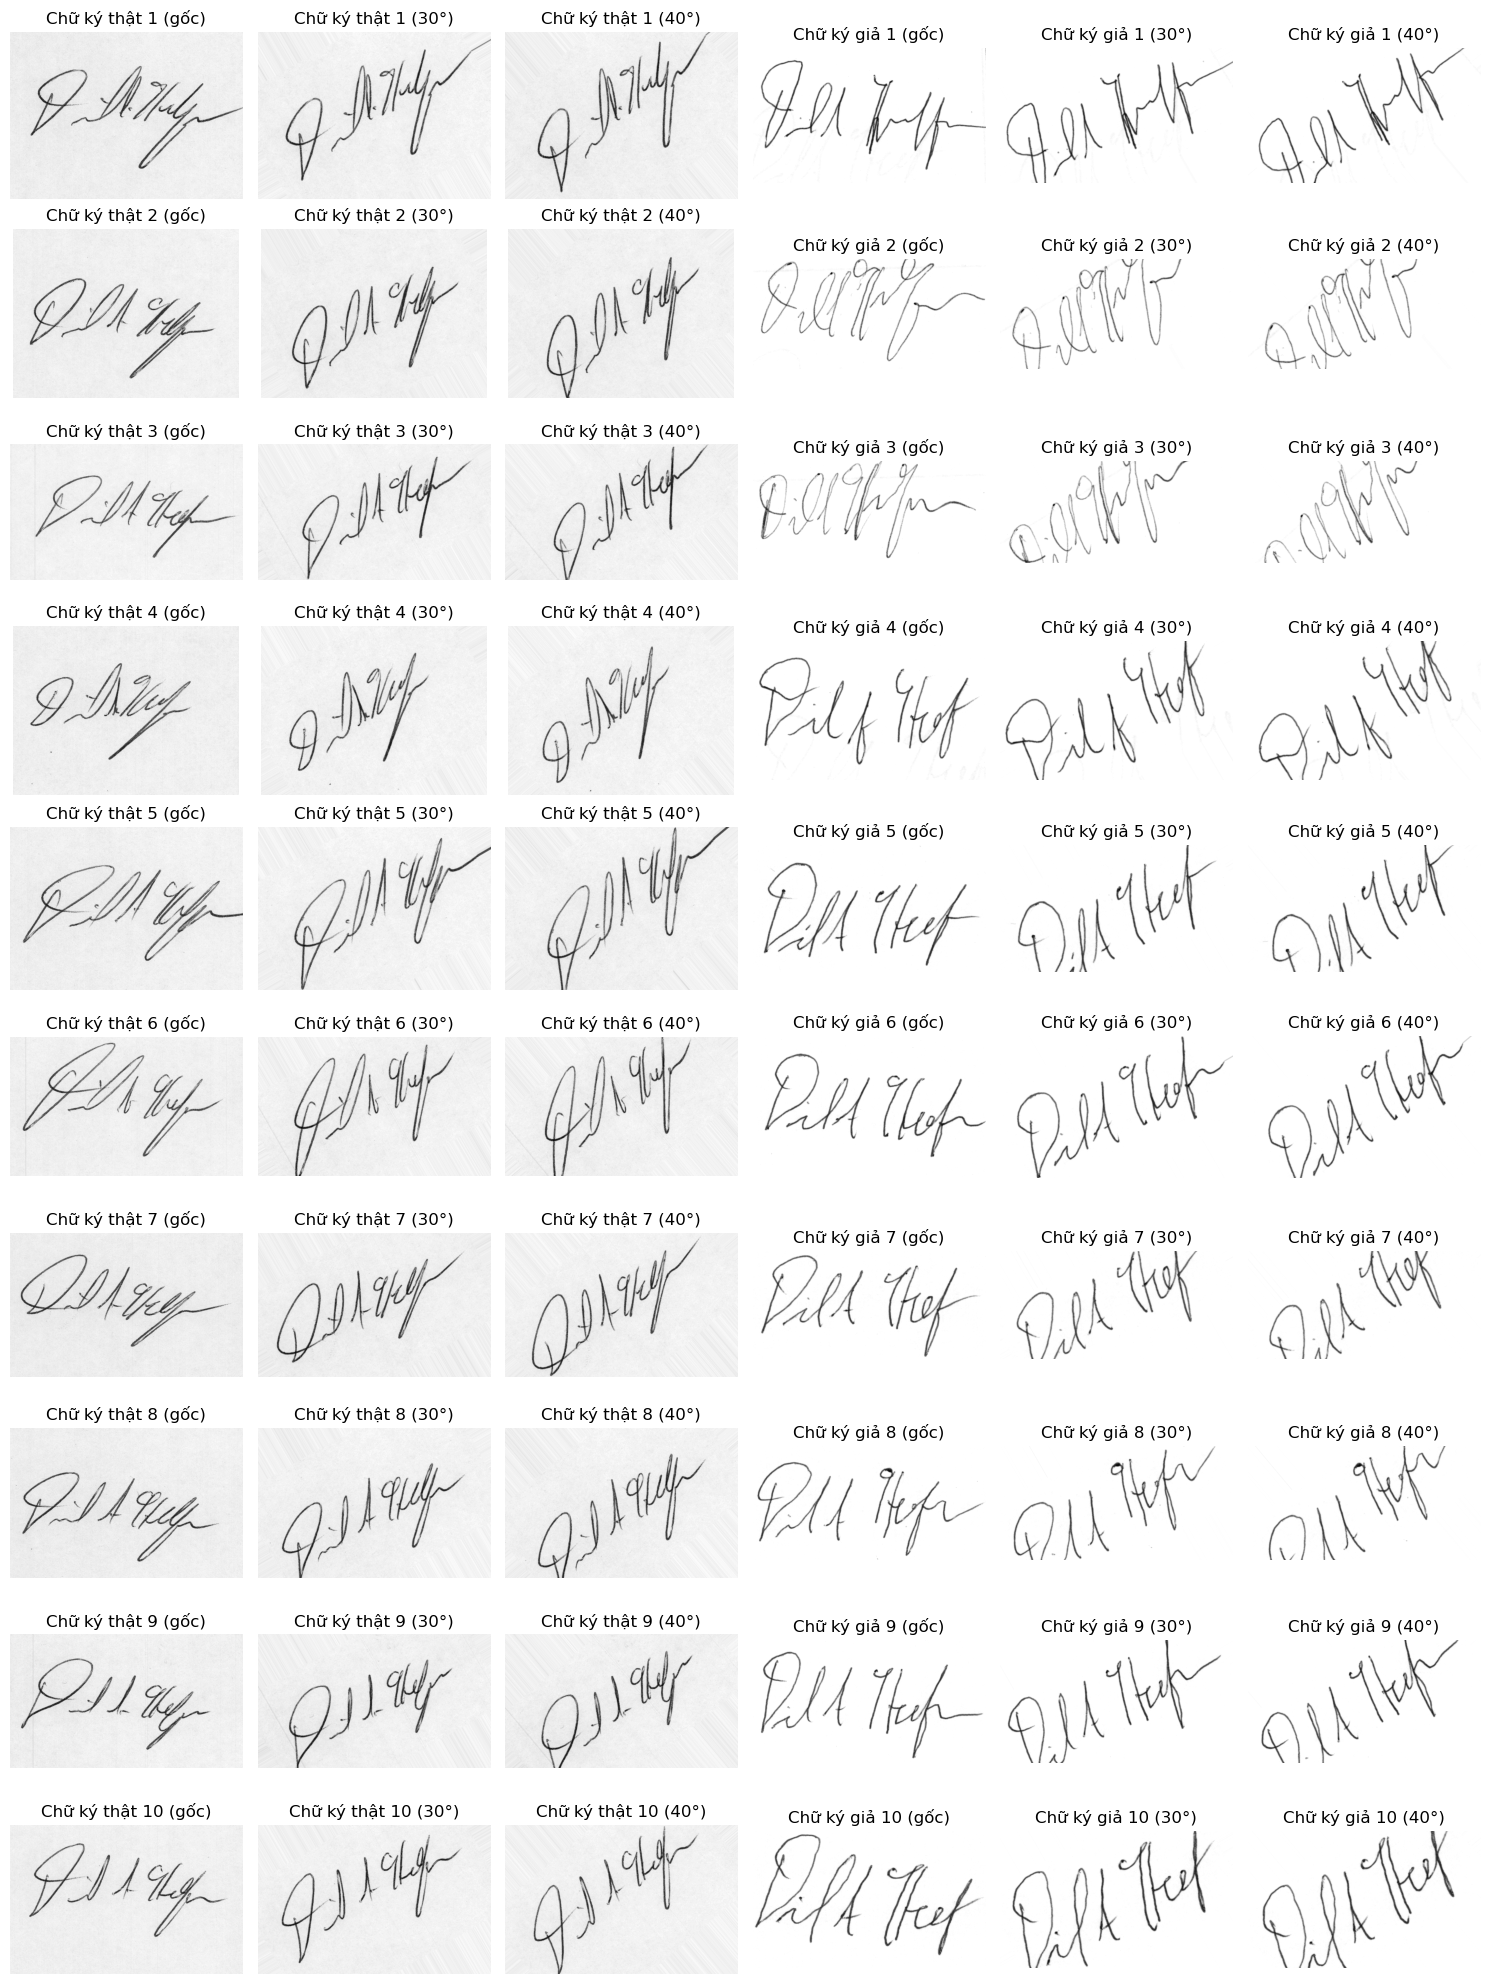

In [405]:
# Show 
import os
import cv2
import matplotlib.pyplot as plt

# Hiển thị các chữ ký liên quan cùng mẫu (bao gồm các phiên bản xoay)
def show_signature_pairs(real_folder, fake_folder, num_samples=5):
    # Lọc danh sách file hợp lệ (bỏ qua Thumbs.db)
    real_files = sorted([f for f in os.listdir(real_folder) if not f.lower().endswith(".db")])
    fake_files = sorted([f for f in os.listdir(fake_folder) if not f.lower().endswith(".db")])

    # Lọc các file gốc (không có tiền tố "rotated_")
    real_originals = [f for f in real_files if not f.startswith("rotated_")]
    fake_originals = [f for f in fake_files if not f.startswith("rotated_")]

    num_samples = min(num_samples, len(real_originals), len(fake_originals))

    # Số cột: 3 cho chữ ký thật (gốc + 2 góc xoay) và 3 cho chữ ký giả (tổng cộng 6 cột)
    plt.figure(figsize=(15, num_samples * 2))  # Điều chỉnh kích thước để cân đối

    for i in range(num_samples):
        # Lấy tên file gốc
        real_base_name = real_originals[i]  # Ví dụ: original_1_1
        fake_base_name = fake_originals[i]  # Ví dụ: forgeries_1_1

        # Tạo danh sách các file liên quan (gốc + xoay) cho chữ ký thật
        real_related_files = [real_base_name]  # Bắt đầu với file gốc
        for angle in [30,40]:  # Chỉ giữ các góc 20° và 30°
            rotated_file = f"rotated_{angle}_{real_base_name}"
            if rotated_file in real_files:
                real_related_files.append(rotated_file)

        # Tạo danh sách các file liên quan (gốc + xoay) cho chữ ký giả
        fake_related_files = [fake_base_name]  # Bắt đầu với file gốc
        for angle in [30,40]:  # Chỉ giữ các góc 20° và 30°
            rotated_file = f"rotated_{angle}_{fake_base_name}"
            if rotated_file in fake_files:
                fake_related_files.append(rotated_file)

        # Hiển thị chữ ký thật
        for j, real_file in enumerate(real_related_files[:3]):  # Giới hạn 3 file (gốc + 2 xoay)
            real_path = os.path.join(real_folder, real_file)
            real_img = cv2.imread(real_path, cv2.IMREAD_GRAYSCALE)

            if real_img is None:
                print(f"Lỗi đọc ảnh: {real_path}")
                continue

            plt.subplot(num_samples, 6, i * 6 + j + 1)  # Cột 1-3 cho chữ ký thật
            plt.imshow(real_img, cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f"Chữ ký thật {i+1} (gốc)")
            else:
                angle = real_file.split('_')[1]  # Lấy góc xoay từ tên file
                plt.title(f"Chữ ký thật {i+1} ({angle}°)")
        
        # Hiển thị chữ ký giả
        for j, fake_file in enumerate(fake_related_files[:3]):  # Giới hạn 3 file (gốc + 2 xoay)
            fake_path = os.path.join(fake_folder, fake_file)
            fake_img = cv2.imread(fake_path, cv2.IMREAD_GRAYSCALE)

            if fake_img is None:
                print(f"Lỗi đọc ảnh: {fake_path}")
                continue

            plt.subplot(num_samples, 6, i * 6 + j + 4)  # Cột 4-6 cho chữ ký giả
            plt.imshow(fake_img, cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f"Chữ ký giả {i+1} (gốc)")
            else:
                angle = fake_file.split('_')[1]  # Lấy góc xoay từ tên file
                plt.title(f"Chữ ký giả {i+1} ({angle}°)")
    
    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị
show_signature_pairs(AUGMENTED_REAL_PATH, AUGMENTED_FAKE_PATH, num_samples=10)

In [407]:
# Xử lý dữ liệu 
# Resize ảnh về 128x128
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize ảnh về 128x128
            images.append(img)
            labels.append(label)
    return images, labels

# Load dữ liệu chữ ký thật và giả từ thư mục đã tăng cường
real_images, real_labels = load_images_from_folder(AUGMENTED_REAL_PATH, 1)  # 1: Chữ ký thật
fake_images, fake_labels = load_images_from_folder(AUGMENTED_FAKE_PATH, 0)  # 0: Chữ ký giả

# Kết hợp dữ liệu
X = np.array(real_images + fake_images).reshape(-1, 128, 128, 1) / 255.0  # Chuẩn hóa ảnh về [0,1]
y = np.array(real_labels + fake_labels)

In [409]:

# Chia tập train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# In kích thước các tập
print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập validation:", X_val.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

# Kiểm tra tỷ lệ lớp trong các tập 
print("Tỷ lệ lớp trong y_train:", np.bincount(y_train) / len(y_train))
print("Tỷ lệ lớp trong y_val:", np.bincount(y_val) / len(y_val))
print("Tỷ lệ lớp trong y_test:", np.bincount(y_test) / len(y_test))

Kích thước tập huấn luyện: (4752, 128, 128, 1)
Kích thước tập validation: (1584, 128, 128, 1)
Kích thước tập kiểm tra: (1584, 128, 128, 1)
Tỷ lệ lớp trong y_train: [0.5 0.5]
Tỷ lệ lớp trong y_val: [0.5 0.5]
Tỷ lệ lớp trong y_test: [0.5 0.5]


Epoch 1/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 52s 326ms/step - accuracy: 0.5386 - loss: 0.6838 - val_accuracy: 0.6597 - val_loss: 0.6182 - learning_rate: 1.5000e-04
Epoch 2/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 45s 304ms/step - accuracy: 0.6787 - loss: 0.6123 - val_accuracy: 0.6768 - val_loss: 0.5932 - learning_rate: 1.5000e-04
Epoch 3/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 44s 297ms/step - accuracy: 0.6879 - loss: 0.5732 - val_accuracy: 0.6894 - val_loss: 0.5867 - learning_rate: 1.5000e-04
Epoch 4/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 44s 297ms/step - accuracy: 0.7103 - loss: 0.5444 - val_accuracy: 0.7689 - val_loss: 0.4739 - learning_rate: 1.5000e-04
Epoch 5/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - accuracy: 0.7677 - loss: 0.4838 - val_accuracy: 0.8548 - val_loss: 0.3881 - learning_rate: 1.5000e-04
Epoch 6/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.8248 - loss: 0.3954 - val_accuracy: 0.9508 - val_loss: 0.1983 - learning_rate: 1.5000e-04
Epoch 7/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 44s 29

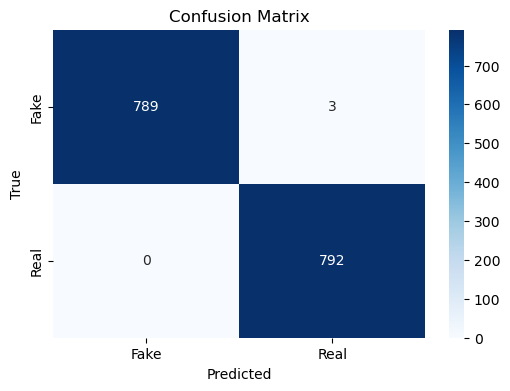

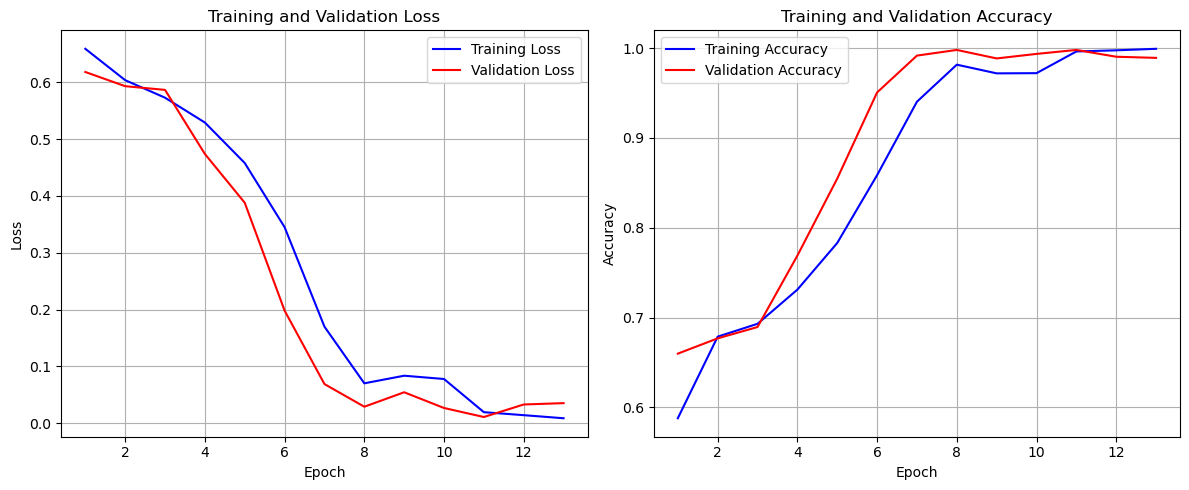

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


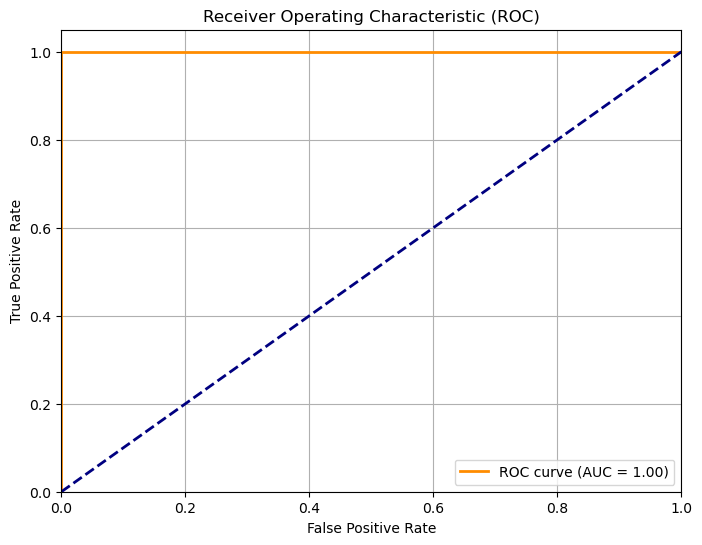

AUC: 1.0000
Epoch 1/13 - accuracy: 0.5878 - loss: 0.6590 - val_accuracy: 0.6597 - val_loss: 0.6182
Epoch 2/13 - accuracy: 0.6787 - loss: 0.6038 - val_accuracy: 0.6768 - val_loss: 0.5932
Epoch 3/13 - accuracy: 0.6930 - loss: 0.5730 - val_accuracy: 0.6894 - val_loss: 0.5867
Epoch 4/13 - accuracy: 0.7311 - loss: 0.5293 - val_accuracy: 0.7689 - val_loss: 0.4739
Epoch 5/13 - accuracy: 0.7830 - loss: 0.4580 - val_accuracy: 0.8548 - val_loss: 0.3881
Epoch 6/13 - accuracy: 0.8586 - loss: 0.3451 - val_accuracy: 0.9508 - val_loss: 0.1983
Epoch 7/13 - accuracy: 0.9404 - loss: 0.1701 - val_accuracy: 0.9918 - val_loss: 0.0691
Epoch 8/13 - accuracy: 0.9817 - loss: 0.0704 - val_accuracy: 0.9981 - val_loss: 0.0292
Epoch 9/13 - accuracy: 0.9720 - loss: 0.0838 - val_accuracy: 0.9886 - val_loss: 0.0546
Epoch 10/13 - accuracy: 0.9722 - loss: 0.0780 - val_accuracy: 0.9937 - val_loss: 0.0270
Epoch 11/13 - accuracy: 0.9964 - loss: 0.0196 - val_accuracy: 0.9981 - val_loss: 0.0111
Epoch 12/13 - accuracy: 0.997

In [421]:
# Final model 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Huấn luyện mô hình CNN
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile mô hình
cnn_model.compile(optimizer=Adam(learning_rate=0.00015),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Thêm callbacks: ReduceLROnPlateau và EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=13,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping]
)

# Đánh giá mô hình trên tập validate
cnn_loss, cnn_acc = cnn_model.evaluate(X_val, y_val)
print(f"\nCNN Accuracy: {cnn_acc:.4f}")

# Dự đoán trên tập validate
y_val_pred = (cnn_model.predict(X_val) > 0.5).astype(int).flatten()

# Tính Precision, Recall, F1-score
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Tính Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Vẽ biểu đồ Loss và Accuracy
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ biểu đồ Loss và Accuracy
plot_training_history(history_cnn)

# Vẽ ROC Curve và tính AUC
y_val_pred_prob = cnn_model.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.4f}")

# In chi tiết accuracy và loss qua từng epoch
for epoch in range(len(history_cnn.history['accuracy'])):
    print(f"Epoch {epoch+1}/{len(history_cnn.history['accuracy'])} - "
          f"accuracy: {history_cnn.history['accuracy'][epoch]:.4f} - "
          f"loss: {history_cnn.history['loss'][epoch]:.4f} - "
          f"val_accuracy: {history_cnn.history['val_accuracy'][epoch]:.4f} - "
          f"val_loss: {history_cnn.history['val_loss'][epoch]:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


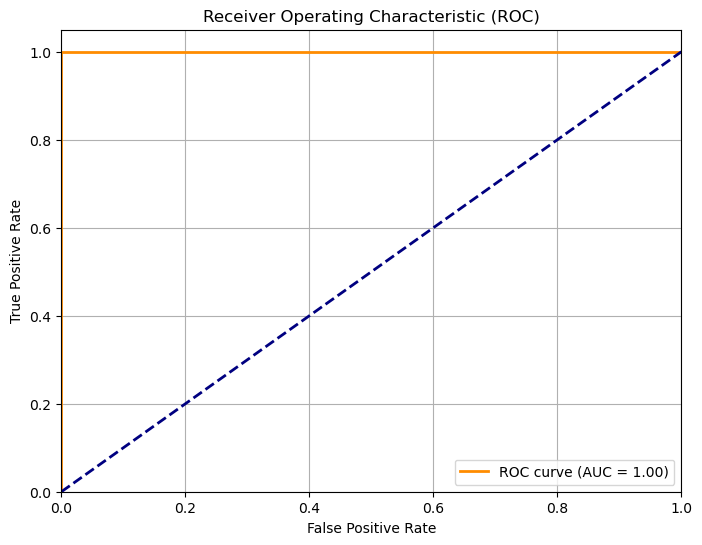

AUC: 1.0000


In [425]:
# Vẽ ROC Curve và tính AUC tren tap test
y_test_pred_prob = cnn_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.4f}")

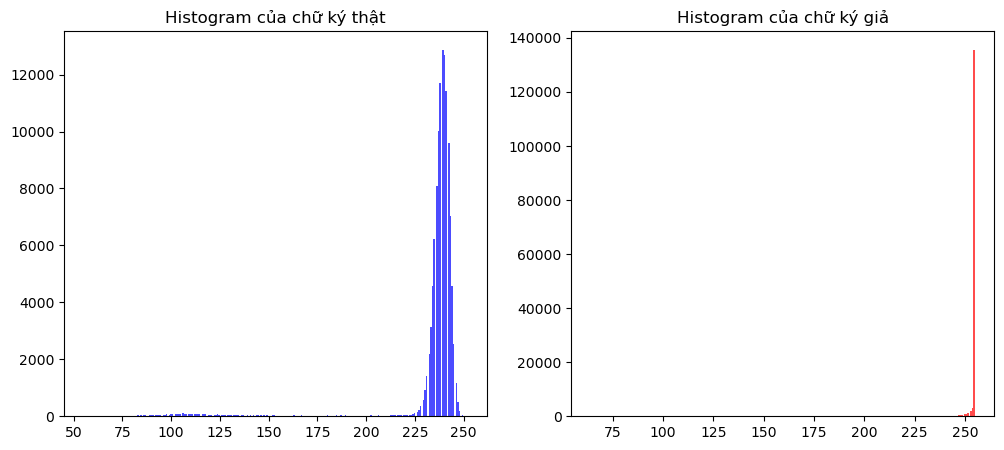

In [429]:
#Khai phá dữ liệu (EDA)
# Kiểm tra phân phối pixel trong ảnh
# Chọn một số ảnh ngẫu nhiên
sample_real = cv2.imread(os.path.join(REAL_PATH, random.choice(os.listdir(REAL_PATH))), cv2.IMREAD_GRAYSCALE)
sample_fake = cv2.imread(os.path.join(FAKE_PATH, random.choice(os.listdir(FAKE_PATH))), cv2.IMREAD_GRAYSCALE)

# Hiển thị histogram pixel
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(sample_real.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("Histogram của chữ ký thật")

plt.subplot(1, 2, 2)
plt.hist(sample_fake.ravel(), bins=256, color='red', alpha=0.7)
plt.title("Histogram của chữ ký giả")

plt.show()



In [ ]:
#Biểu đồ bên trái (Chữ ký thật - màu xanh):
#Phần lớn pixel tập trung ở khoảng 230 - 250 (gần màu trắng).
# Một số ít pixel có giá trị thấp hơn nhưng rất ít.

#Biểu đồ bên phải (Chữ ký giả - màu đỏ):
#Pixel chủ yếu tập trung gần 250 - 255 (gần như toàn bộ là màu trắng).
#Gần như không có pixel có giá trị thấp hơn.

#Chữ ký giả có nhiều pixel gần với màu trắng tuyệt đối (255) hơn so với chữ ký thật.
#Chữ ký thật có mức xám đa dạng hơn, trong khi chữ ký giả có độ tương phản cao hơn (có thể là do nền trắng rõ rệt).

In [57]:
# Khám phá dữ liệu (EDA)
# Kiểm tra kích thước ảnh

img_shapes = []

for img_name in os.listdir(REAL_PATH)[:10]:  # Kiểm tra 10 ảnh
    img = cv2.imread(os.path.join(REAL_PATH, img_name), cv2.IMREAD_GRAYSCALE)
    img_shapes.append(img.shape)

print("Kích thước ảnh chữ ký thật:", set(img_shapes))

img_shapes = []

for img_name in os.listdir(FAKE_PATH)[:10]:  # Kiểm tra 10 ảnh
    img = cv2.imread(os.path.join(FAKE_PATH, img_name), cv2.IMREAD_GRAYSCALE)
    img_shapes.append(img.shape)

print("Kích thước ảnh chữ ký giả:", set(img_shapes))

Kích thước ảnh chữ ký thật: {(355, 576), (385, 534), (409, 546), (331, 576), (384, 546), (414, 552), (349, 582), (342, 588), (373, 582), (367, 570)}
Kích thước ảnh chữ ký giả: {(263, 563), (360, 618), (329, 620), (258, 588), (288, 606), (318, 584), (301, 616), (354, 594), (361, 591), (312, 529)}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


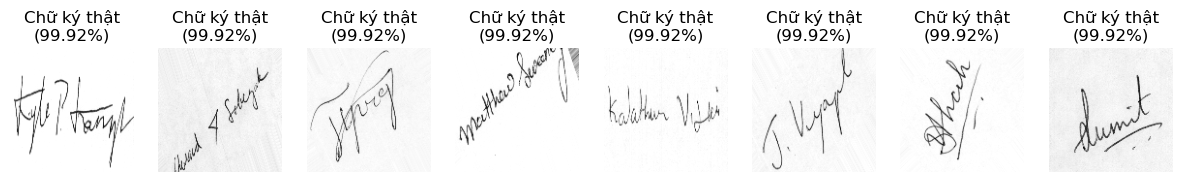

In [427]:
# Dự đoán chữ ký
def predict_signature(img):
    img = cv2.resize(img, (128, 128))  # Resize ảnh về 128x128
    img = img.astype("float32") / 255.0  # Chuẩn hóa ảnh về khoảng [0,1]
    img = img.reshape(1, 128, 128, 1)  # Định dạng lại cho phù hợp với mô hình

    prediction = cnn_model.predict(img)[0][0]  # Sử dụng cnn_model để dự đoán
    label = "Chữ ký thật" if prediction > 0.5 else "Chữ ký giả"
    return label, prediction  # Trả về cả nhãn và xác suất dự đoán

# Chọn ngẫu nhiên một số ảnh từ tập kiểm tra
num_samples = 8
sample_indexes = np.random.choice(len(X_test), num_samples, replace=False)
plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indexes):
    img = X_test[idx].reshape(128, 128)  # Lấy ảnh từ tập kiểm tra
    label, confidence = predict_signature(img)  # Dự đoán chữ ký
    
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"{label}\n({confidence:.2%})")  # Hiển thị dự đoán và xác suất

plt.show()
